# Análise Exploratória de sinais de ECG


In [31]:
import pandas as pd
import numpy as np
import os

PATH = os.path.abspath('../../')
PATH

'/home/davi/Github/doutorado_ppgee_v2'

In [32]:
# df = pd.read_csv(PATH+'/data/Generalized_seizures_dataset.csv')
df = pd.read_csv(PATH + '/data/data_train.csv')


In [33]:
# Quantidade de Sinas por frquência amostral
df['freq'].value_counts()

256     2522
250      687
400      400
512       82
1000      39
Name: freq, dtype: int64

In [34]:
# Contagem de eventos por Arquivo
df['path'].value_counts()

train/01_tcp_ar/000/00000077/s003_2010_01_21/00000077_s003_t000.tse      1
train/01_tcp_ar/127/00012742/s007_2015_04_07/00012742_s007_t004.tse      1
train/01_tcp_ar/127/00012742/s005_2015_04_05/00012742_s005_t005.tse      1
train/01_tcp_ar/127/00012742/s005_2015_04_05/00012742_s005_t007.tse      1
train/01_tcp_ar/127/00012742/s005_2015_04_05/00012742_s005_t008.tse      1
                                                                        ..
train/01_tcp_ar/092/00009231/s004_2012_10_07/00009231_s004_t006.tse      1
train/01_tcp_ar/092/00009231/s004_2012_10_07/00009231_s004_t008.tse      1
train/01_tcp_ar/092/00009231/s005_2012_10_07/00009231_s005_t000.tse      1
train/01_tcp_ar/092/00009231/s005_2012_10_07/00009231_s005_t001.tse      1
train/03_tcp_ar_a/131/00013145/s003_2015_09_01/00013145_s003_t003.tse    1
Name: path, Length: 3730, dtype: int64

OBS: usaremos inicialmente sinais com frequência amostral de 256 Hz

In [35]:
df = df[df['freq'] == 256].reset_index(drop=True)

## Carregando e Organizando dados

In [36]:
files = df['path'].unique()

## Tentativa de processamento de ECG

In [37]:
import os
from dotenv import load_dotenv

load_dotenv()

PATH = os.path.abspath('')

pwd = os.getenv('TUH_PASSWORD')
user = os.getenv('TUH_USER')
path_data = os.getenv('PATH_DATASET')

## Experimento com um único arquivo

In [38]:
# Carregando .edf
import mne

file = files[0].replace('tse', 'edf')

data = mne.io.read_raw_edf(path_data + '/' + file)
info = data.info
info

Extracting EDF parameters from /media/davi/2526467b-9f07-4ce5-9425-6d2b458567b7/home/davi/www.isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_seizure/v1.5.2/edf/train/01_tcp_ar/004/00000458/s011_2014_06_24/00000458_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Info | 7 non-empty values
 bads: []
 ch_names: EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-REF, EEG C3-REF, ...
 chs: 29 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2014-06-24 10:44:41 UTC
 nchan: 29
 projs: []
 sfreq: 256.0 Hz
>

In [39]:
# canais de ecg
ch_ecg = [ch for ch in info.ch_names if 'EKG' in ch]
ch_ecg

['EEG EKG1-REF']

<AxesSubplot:>

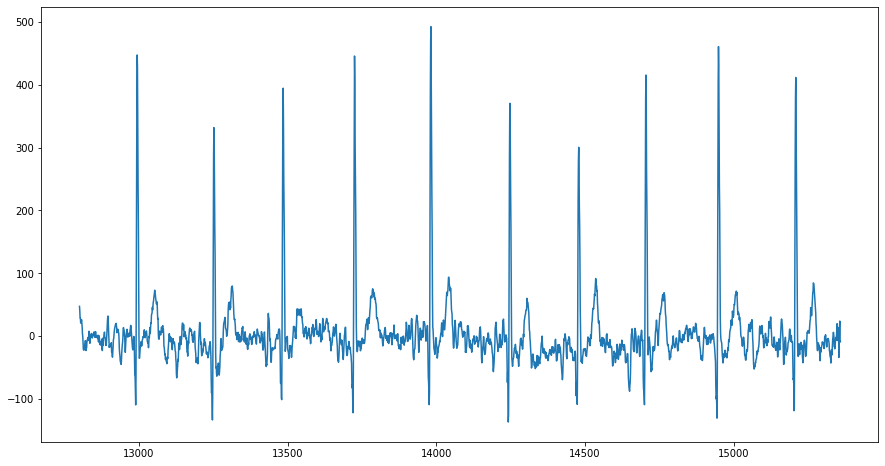

In [40]:
# Canal de ECG puro 

import matplotlib.pyplot as plt

edf = data.to_data_frame()

ecg = edf['EEG EKG1-REF'][256 * 50:256 * 60] * (-1)

fig = plt.figure(figsize=[15, 8])

ecg.plot()

## Processando ECG

### Métodos para filtragem de ECG

<AxesSubplot:>

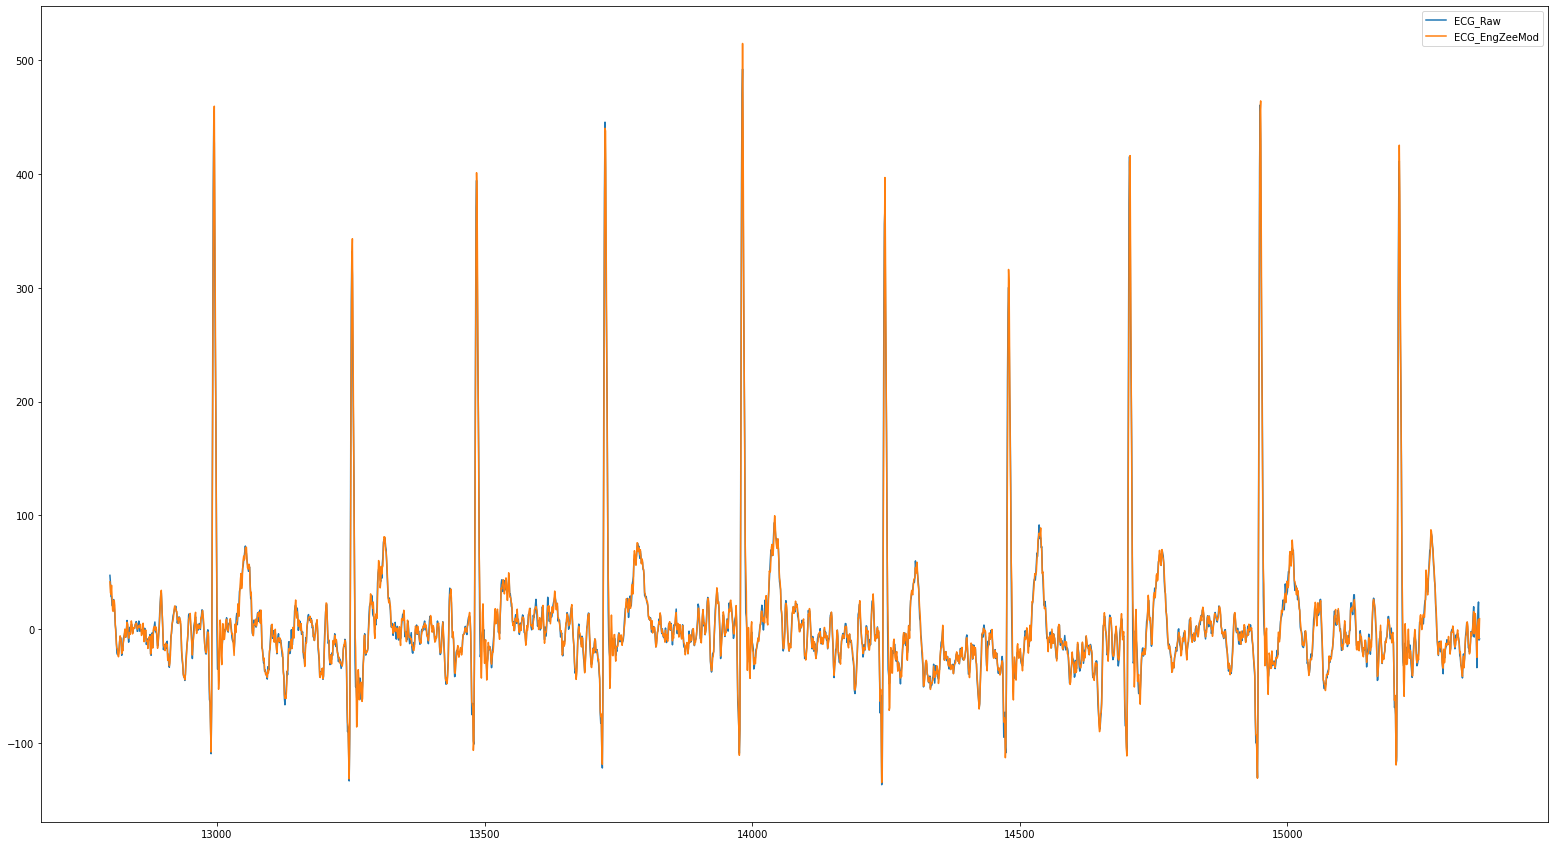

In [41]:
# https://neurokit2.readthedocs.io/en/latest/_modules/neurokit2/ecg/ecg_clean.html

import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt

# ecg = #nk.ecg_simulate(duration=10, sampling_rate=1000)
signals = pd.DataFrame({
    "ECG_Raw": ecg,
    # "ECG_NeuroKit": nk.ecg_clean(ecg, sampling_rate=256, method="neurokit"),
    # "ECG_BioSPPy": nk.ecg_clean(ecg, sampling_rate=256, method="biosppy"),
    # "ECG_PanTompkins": nk.ecg_clean(ecg, sampling_rate=256, method="pantompkins1985"),
    # "ECG_Hamilton": nk.ecg_clean(ecg, sampling_rate=256, method="hamilton2002"),
    # "ECG_Elgendi": nk.ecg_clean(ecg, sampling_rate=256, method="elgendi2010"), ## Não
    "ECG_EngZeeMod": nk.ecg_clean(ecg, sampling_rate=256, method="engzeemod2012")
})

"""
From https://github.com/berndporr/py-ecg-detectors/

- C. Zeelenberg, A single scan algorithm for QRS detection and feature extraction, IEEE Comp. in Cardiology, vol. 6, pp. 37-42, 1979.

- A. Lourenco, H. Silva, P. Leite, R. Lourenco and A. Fred, "Real Time Electrocardiogram Segmentation for Finger Based ECG Biometrics", BIOSIGNALS 2012, pp. 49-54, 2012.
"""

signals.plot(figsize=(27, 15))

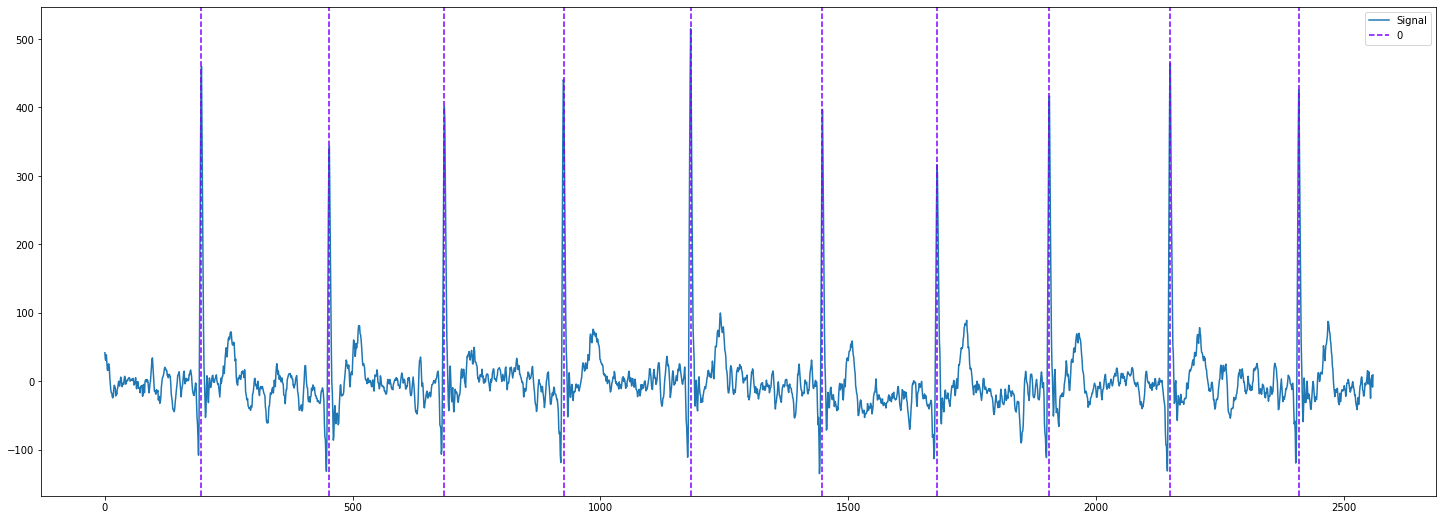

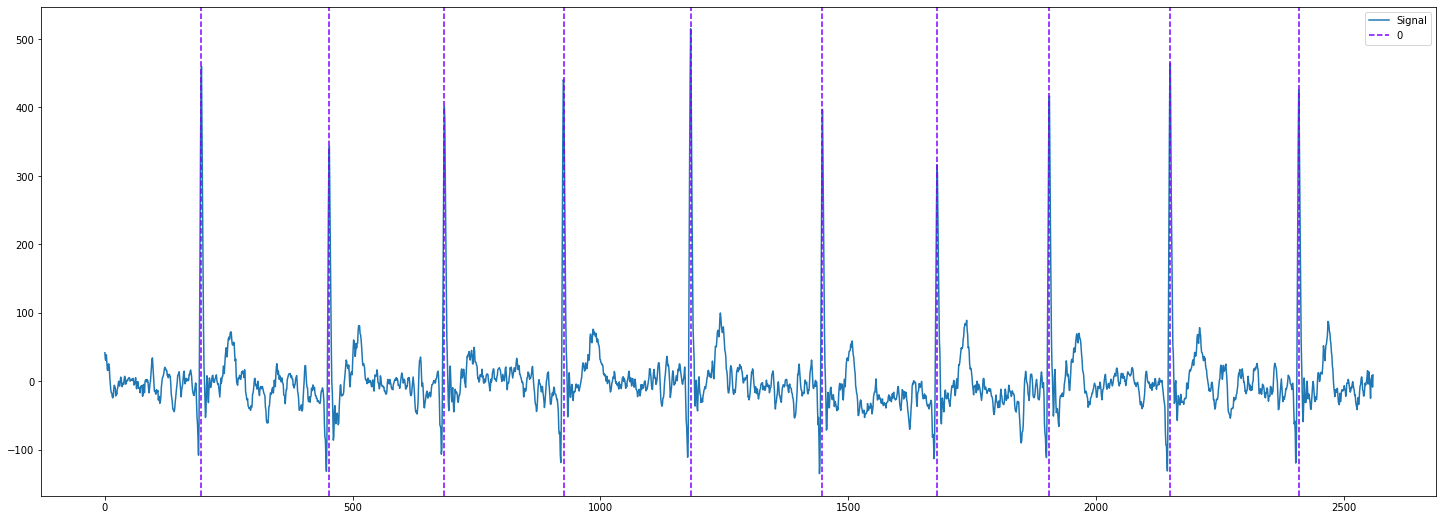

In [42]:
# https://neurokit2.readthedocs.io/en/latest/_modules/neurokit2/ecg/ecg_findpeaks.html

import neurokit2 as nk

# ecg = nk.ecg_simulate(duration=10, sampling_rate=1000)
cleaned = nk.ecg_clean(ecg, sampling_rate=256,method="engzeemod2012")
info = nk.ecg_findpeaks(cleaned)

neurokit = nk.ecg_findpeaks(nk.ecg_clean(ecg, method="neurokit"), method="neurokit")
pantompkins1985 = nk.ecg_findpeaks(nk.ecg_clean(ecg, method="pantompkins1985"), method="pantompkins1985")
nabian2018 = nk.ecg_findpeaks(cleaned, method="nabian2018")
hamilton2002 = nk.ecg_findpeaks(nk.ecg_clean(ecg, method="hamilton2002"), method="hamilton2002")
martinez2003 = nk.ecg_findpeaks(cleaned, method="martinez2003")  ## ESSE
christov2004 = nk.ecg_findpeaks(cleaned, method="christov2004")
gamboa2008 = nk.ecg_findpeaks(nk.ecg_clean(ecg, method="gamboa2008"), method="gamboa2008")
elgendi2010 = nk.ecg_findpeaks(nk.ecg_clean(ecg, method="elgendi2010"), method="elgendi2010")
# engzeemod2012 = nk.ecg_findpeaks(nk.ecg_clean(ecg, method="engzeemod2012"), method="engzeemod2012")
kalidas2017 = nk.ecg_findpeaks(nk.ecg_clean(ecg, method="kalidas2017"), method="kalidas2017")
# rodrigues2021 = nk.ecg_findpeaks(cleaned, method="rodrigues2021")

plt.rcParams['figure.figsize'] = [25, 9]
nk.events_plot([
    # neurokit["ECG_R_Peaks"],
                # pantompkins1985["ECG_R_Peaks"],
                # nabian2018["ECG_R_Peaks"],
                # hamilton2002["ECG_R_Peaks"],
                # christov2004["ECG_R_Peaks"],
                # gamboa2008["ECG_R_Peaks"],
                # elgendi2010["ECG_R_Peaks"],
                # engzeemod2012["ECG_R_Peaks"],
                # kalidas2017["ECG_R_Peaks"],
                martinez2003["ECG_R_Peaks"]
                # rodrigues2021["ECG_R_Peaks"]
                ], cleaned)


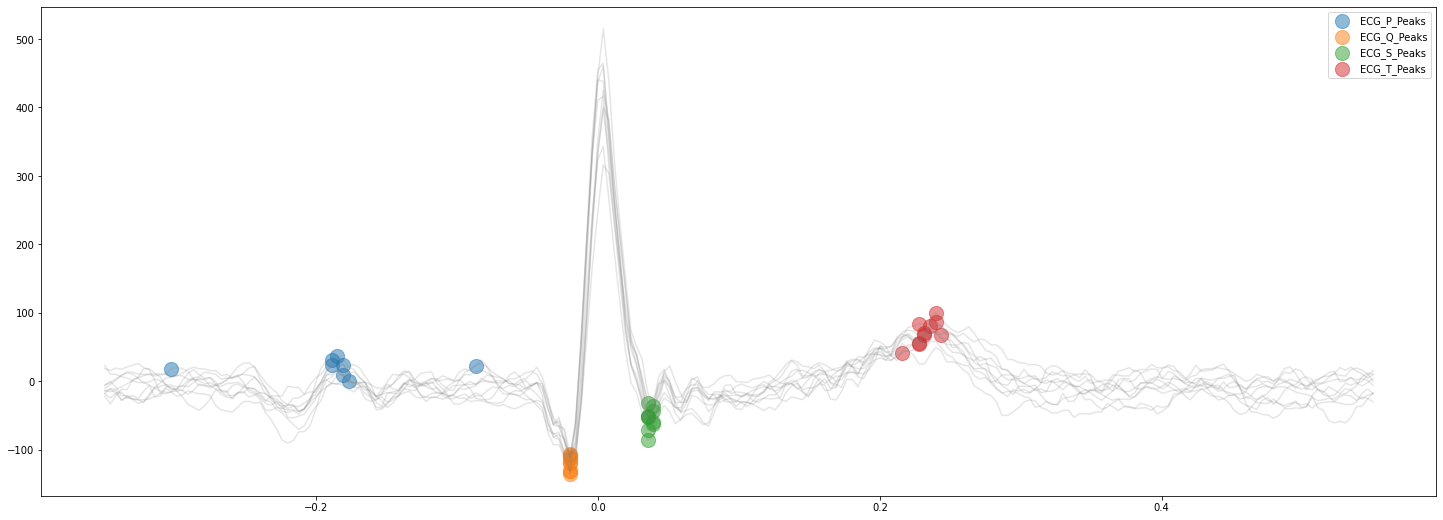

In [43]:
ecg_ = nk.ecg_clean(ecg, sampling_rate=256, method="engzeemod2012")

rr_ = nk.ecg_findpeaks(cleaned, method="martinez2003")["ECG_R_Peaks"]

_, waves_peak = nk.ecg_delineate(ecg_, rr_, sampling_rate=256, show=True, show_type='peaks')


,Signal,Index,Label
-0.336484,-27.405343,108,1
-0.332574,-21.813898,109,1
-0.328664,-26.479798,110,1
-0.324754,-32.183502,111,1
-0.320844,-29.829888,112,1
...,...,...,...
0.465052,-11.063809,313,1
0.468962,-7.897321,314,1
0.472872,-7.466251,315,1
0.476782,-10.949657,316,1


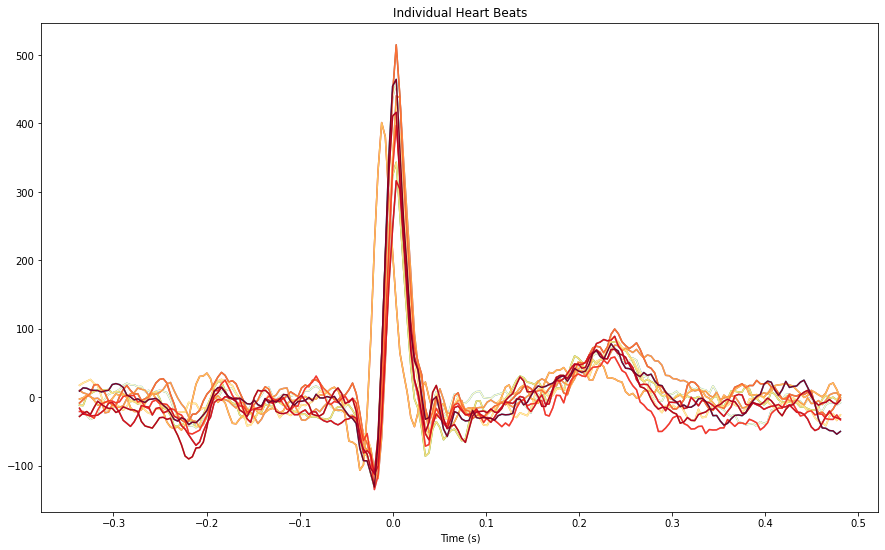

In [51]:
epochs = nk.ecg_segment(ecg_, rpeaks=None, sampling_rate=256, show=True)

epochs['1']

In [45]:
import neurokit2 as nk

signals, info = nk.ecg_process(ecg_signal=ecg, sampling_rate=256)

In [28]:
info.keys()

dict_keys(['ECG_R_Peaks', 'sampling_rate'])

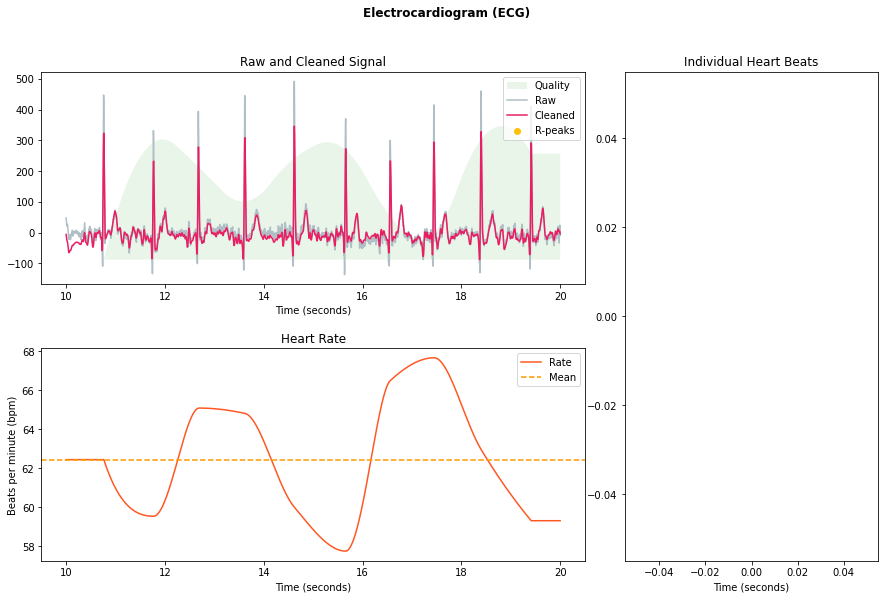

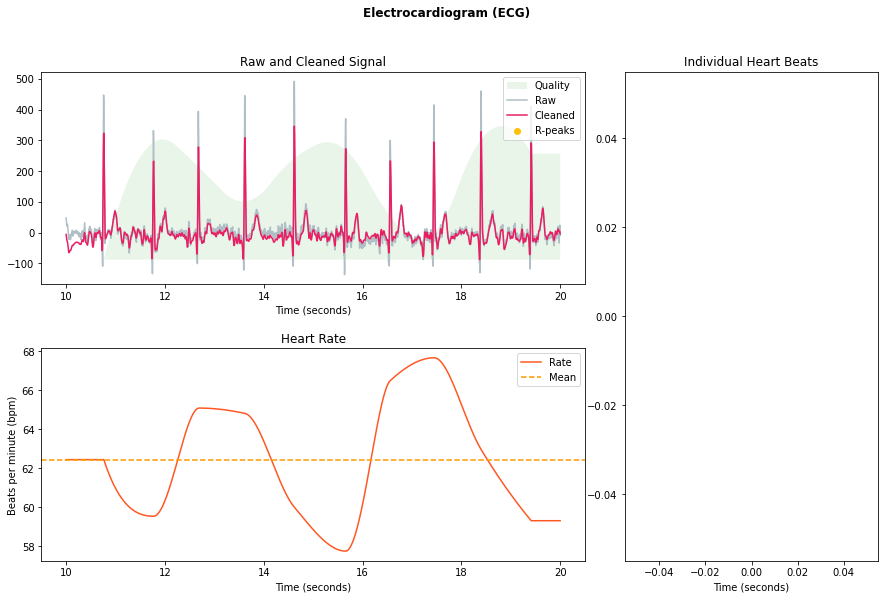

In [46]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 9]
nk.ecg_plot(signals, sampling_rate=256)

In [30]:
_, rr = nk.ecg_peaks(ecg, sampling_rate=256)

In [36]:
signals['ECG_Clean'][256 * 50:256 * 60] * (-1)

Series([], Name: ECG_Clean, dtype: float64)

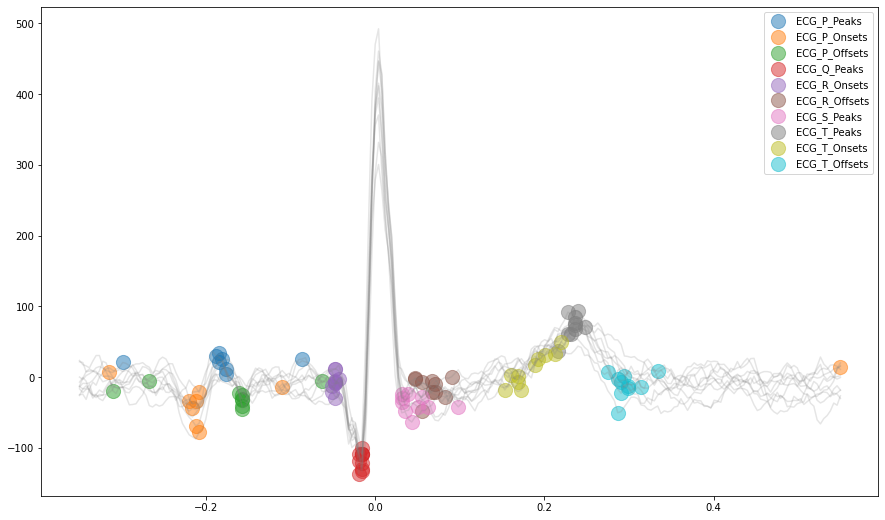

In [31]:
s, w = nk.ecg_delineate(ecg, rr, sampling_rate=256, method="dwt", show=True, show_type='all')

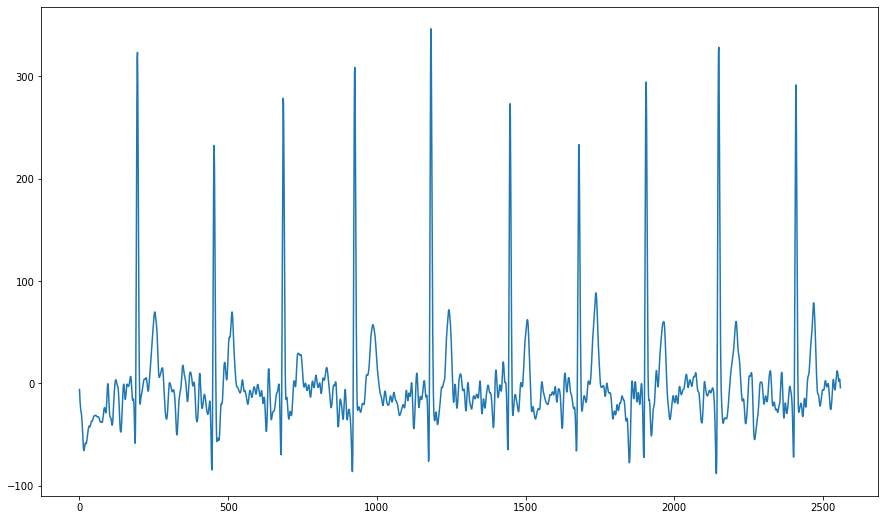

In [40]:
cleaned = nk.ecg_clean(ecg, sampling_rate=256)
plt.plot(cleaned)

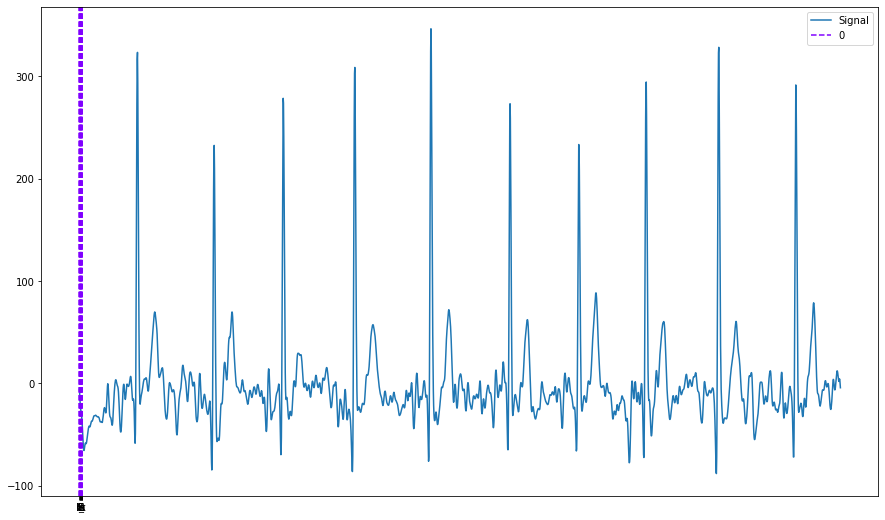

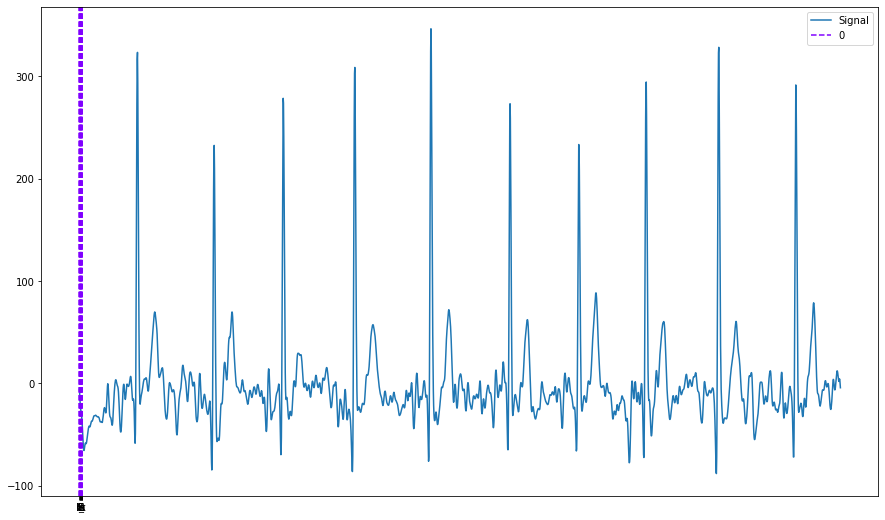

In [49]:
_, rpeaks = nk.ecg_peaks(cleaned, sampling_rate=256)
sig, waves = nk.ecg_delineate(cleaned, rpeaks, sampling_rate=256)

nk.events_plot(['ECG_S_Peaks'], cleaned)
# ['ECG_P_Peaks', 'ECG_Q_Peaks', 'ECG_S_Peaks', 'ECG_T_Peaks']

## Métodos para filtragem de ECG

## Algoritmo para Definição de Intervalo RR

In [61]:
!pip install PyWavelets

     |████████████████████████████████| 4.4 MB 573 kB/s eta 0:00:01
